# PyTorch Model

In [1]:
import pandas as pd

In [2]:
DF=pd.read_csv("Datasets/merged dataset_SDI_median.csv")

In [3]:
DF1=DF.copy()
DF1['net_asset']=DF1['asset']-DF1['liab']
DF1['net_asset']
DF1 = DF1[DF1.columns.difference(['asset', 'liab'])]
DF1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435110 entries, 0 to 435109
Columns: 761 entries, ABCUBK to voliab
dtypes: float64(761)
memory usage: 2.5 GB


In [4]:
# Create Target Variables
Y = DF1["net_asset"]
X = DF1.copy()
X = X.drop(columns=["net_asset"])

In [5]:
# Clear Dataframes for Memory Purposes
DF, DF1 = None, None

# Create PyTorch Experiment

In [6]:
import torch
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
%matplotlib notebook

In [7]:
# Declare Linear Regression in PyTorch

class linearRegression(torch.nn.Module):
    def __init__(self, n_features,n_hidden, n_output):
        super(linearRegression, self).__init__()
        self.hidden = torch.nn.Linear(in_features=n_features, out_features=n_hidden, bias=True)
        self.predict = torch.nn.Linear(in_features=n_hidden, out_features=n_output, bias=True)
        self.dropout = torch.nn.Dropout(0.25)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.predict(x)
        return x

In [8]:
# Make Data Split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)
x_train = torch.tensor(x_train.values)
x_test = torch.tensor(x_test.values)
y_train = torch.tensor(y_train.values).reshape(-1,1)
y_test = torch.tensor(y_test.values).reshape(-1,1)

if torch.cuda.is_available():
    x_train, x_test = x_train.cuda(), x_test.cuda()
    y_train = y_train.cuda()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([304577, 760])
torch.Size([130533, 760])
torch.Size([304577, 1])
torch.Size([130533, 1])


In [14]:
# Setup PyTorch Regression Model
Num_Features = X.shape[1]
learningRate = 0.1
epochs = 50000
hidden_features = 20
output_features = 1
model = linearRegression(Num_Features,hidden_features,output_features)

if torch.cuda.is_available():
    model.cuda()

model

linearRegression(
  (hidden): Linear(in_features=760, out_features=20, bias=True)
  (predict): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [15]:
# Setup Optimizer & Loss Function
criterion = torch.nn.SmoothL1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=0.9, nesterov=True)
scheduler = CosineAnnealingLR(optimizer,T_max=epochs, eta_min=0.0001, last_epoch=-1)

<IPython.core.display.Javascript object>


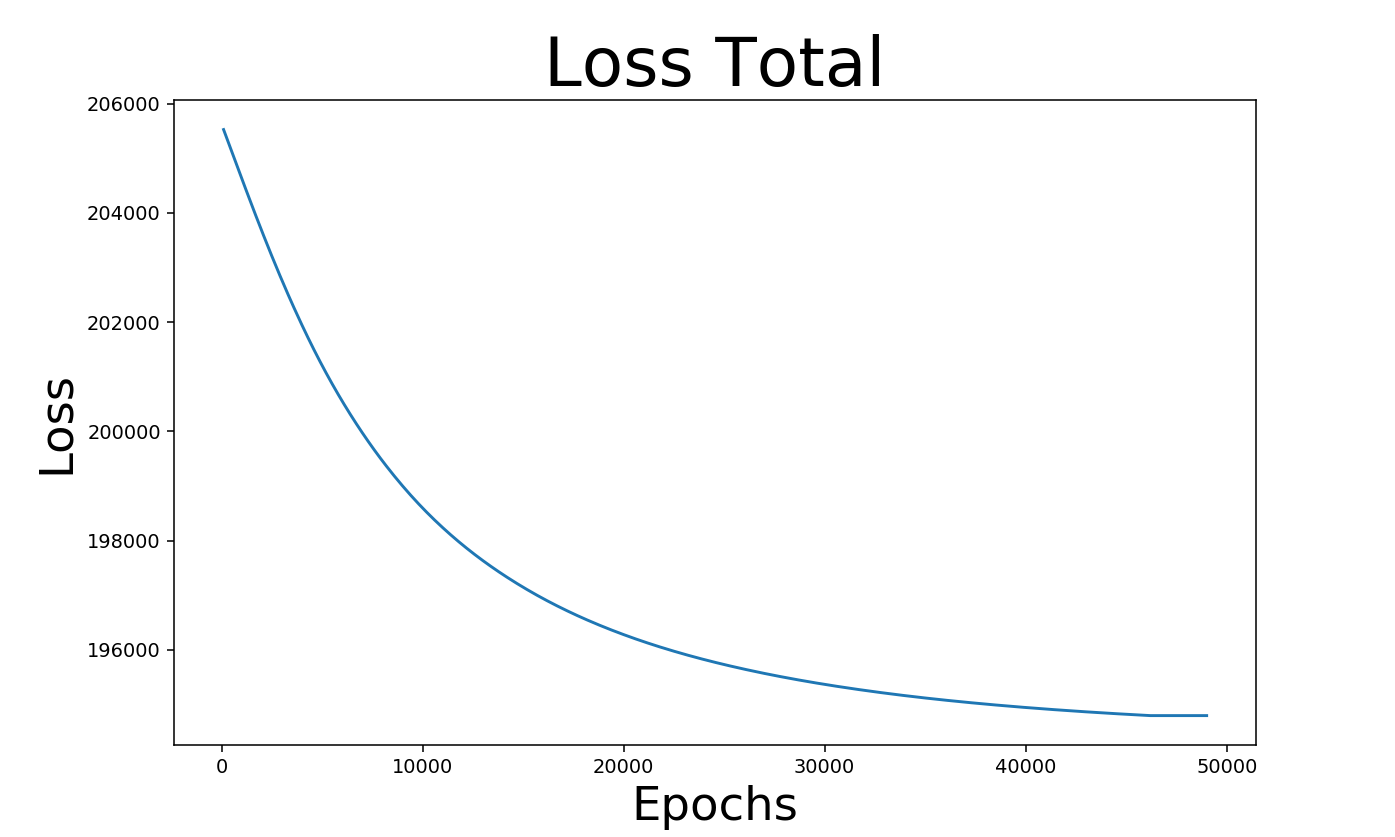

In [16]:
# Empty Cache
my_images = []
loss_list = []
x_range = []
fig, ax = plt.subplots(figsize=(10,6))
for j in tqdm(range(epochs)):
    # Clear Gradients 
    optimizer.zero_grad()
        
    # Train Model
    ## Pass Through Model
    outputs = model.forward(x_train.float())
    ## Calculate Loss Function
    loss = criterion(outputs, y_train.float())
    if j % 100 == 0 and j != 0:
        # Append Iteration
        x_range.append(j)
        # Append Loss
        loss_list.append(loss.item())
    ## Backward Propogation
    loss.backward()

    ## Update Parameters
    optimizer.step()
        
    # Test Model
    with torch.no_grad():
        # Freeze All Layers
        model.eval()
        # Predict Output
        y_hat = model(x_test.float())
        # Calculate MSE
        y_hat = y_hat.detach().cpu().numpy()
    
    # Plot and Show Learning Process
    plot_true = True
    if plot_true == True:
        if j % 1000 == 0:
            plt.cla()
            ax.set_title('Loss Total', fontsize=35)
            ax.set_xlabel('Epochs', fontsize=24)
            ax.set_ylabel('Loss', fontsize=24)
            plt.plot(x_range, loss_list)
            fig.canvas.draw() 

<IPython.core.display.Javascript object>


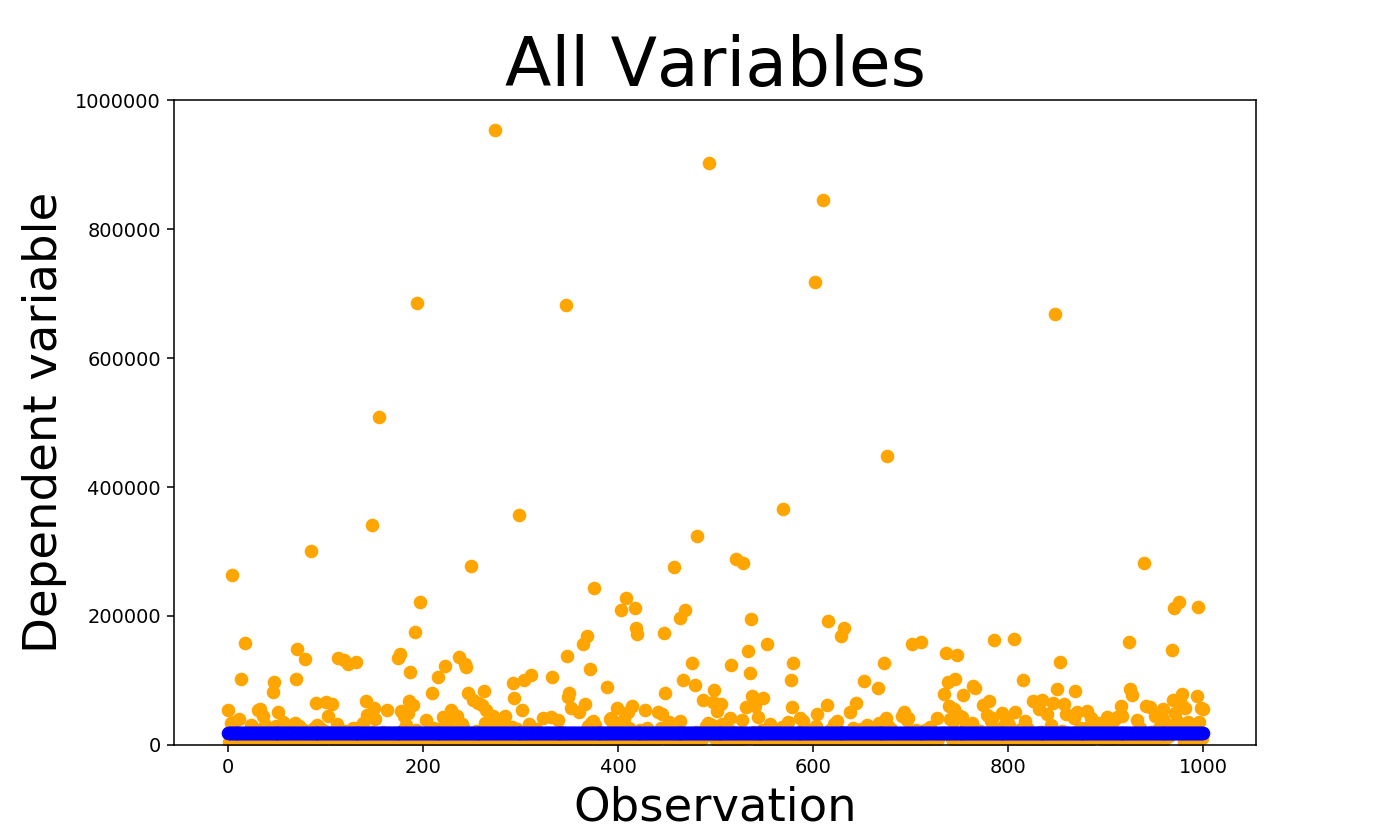

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title('All Variables', fontsize=35)
ax.set_xlabel('Observation', fontsize=24)
ax.set_ylabel('Dependent variable', fontsize=24)
x_range = np.arange(len(y_test))
y_test2 = y_test.clone()
y_test2 = y_test2.detach().cpu().numpy()
ax.scatter(x_range[:1000], y_test2[:1000], color = "orange")
ax.scatter(x_range[:1000], y_hat[:1000], color = "blue")
plt.ylim(bottom=0,top=1000000)
plt.show()

# Create PyTorch K-Fold Experiment

In [18]:
import torch
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [19]:
# Declare Linear Regression in PyTorch

class linearRegression(torch.nn.Module):
    def __init__(self, n_features,n_hidden, n_output):
        super(linearRegression, self).__init__()
        self.hidden = torch.nn.Linear(in_features=n_features, out_features=n_hidden, bias=True)
        self.predict = torch.nn.Linear(in_features=n_hidden, out_features=n_output, bias=True)

    def forward(self, x):
        x = self.hidden(x)
        x = F.relu(x)
        x = self.predict(x)
        return x

In [20]:
# Setup K-Folds
kf = KFold(n_splits=2, random_state=6, shuffle=True)
kf.get_n_splits(X)

2

In [21]:
# Create Lists to Hold Values
MSE_List = []
Variance_List = []
Weights_List = []
Y_Coefficients = []

# List Model 1 Loss
Model_1_Loss = []

In [22]:
i = 0
for train_index, test_index in tqdm(kf.split(X)):
    # Counter
    i += 1
    # Clear Model
    model = None
    torch.cuda.empty_cache()
    
    # Split According to K-Folds
    x_train, x_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]
    
    # Turn Values Into Tensors
    x_train, x_test = torch.tensor(x_train.values), torch.tensor(x_test.values)
    y_train = torch.tensor(y_train.values).reshape(-1,1)
    y_test  = torch.tensor(y_test.values).reshape(-1,1)
    
    # Setup PyTorch Regression Model
    Num_Features = X.shape[1]
    learningRate = 0.1
    epochs = 1000
    hidden_features = 50
    output_features = 1
    model = linearRegression(Num_Features,hidden_features,output_features)
    criterion = torch.nn.SmoothL1Loss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=0.9, nesterov=True)
    scheduler = CosineAnnealingLR(optimizer,T_max=epochs, eta_min=0.0001, last_epoch=-1)
    
    # Run Through the PyTorch Model
    print("Model:",i)
    for j in tqdm(range(epochs)):
        # if GPU is Available
        if torch.cuda.is_available():
            model = model.cuda()
            x_train, y_train = x_train.cuda(), y_train.cuda()
            x_test, y_test = x_test.cuda(), y_test.cuda()
        # Clear Gradients 
        optimizer.zero_grad()
        
        # Train Model
        ## Pass Through Model
        outputs = model.forward(x_train.float())
        ## Calculate Loss Function
        loss = criterion(outputs, y_train.float())
        ## Backward Propogation
        loss.backward()
        # Attach Loss Function
        if i == 1:
            Model_1_Loss.append(loss.item())
        ## Update Parameters
        optimizer.step()
        
        # Test Model
    with torch.no_grad():
        # Freeze All Layers
        model.eval()
        # Predict Output
        y_hat = model(x_test.float())
        # Calculate MSE
        if torch.cuda.is_available():
            y_test = y_test.cpu()
            y_hat = y_hat.cpu()
        y_hat = y_hat.detach().numpy()
        y_test = y_test.detach().numpy()
            
    # Calculate MSE
    MSE = mean_squared_error(y_hat, y_test)
    MSE_List.append(MSE)

Model: 1



Model: 2


## Graph The Loss Function of the First Fold

<IPython.core.display.Javascript object>


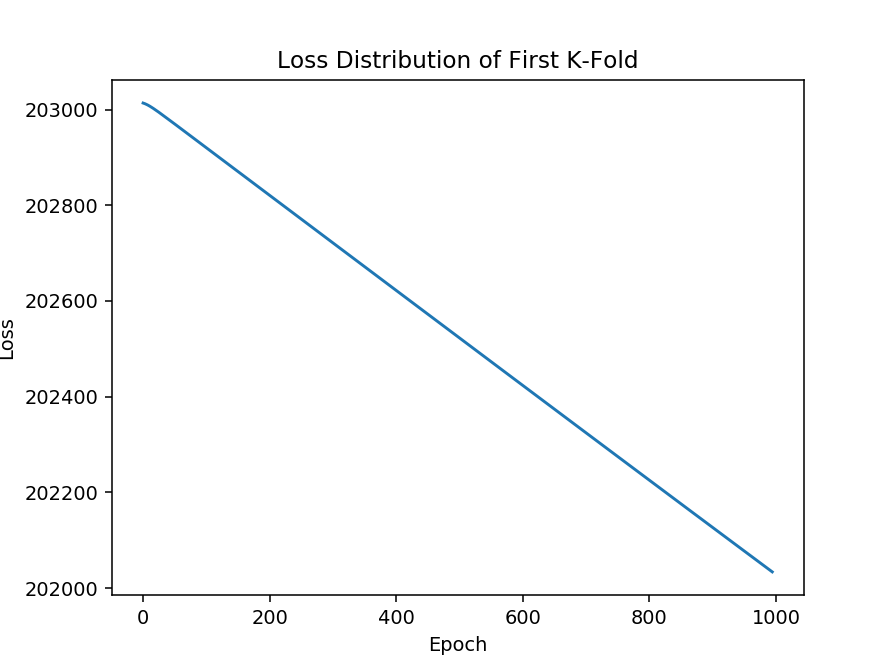

In [23]:
# Graph the Loss for First Model
x_range = np.arange(len(Model_1_Loss))
plt.plot(np.array(Model_1_Loss[5:]))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Distribution of First K-Fold")
plt.show()